# Generation of "Similar" Sequences Using The Recurrent Variational Auto Encoder

# Introduction

I'm doing a thing to generate similar protein sequences, eventually.

In [1]:
# To Try:
# ! Break into training files
# ! with different seq lens. 
# ! Start with longer sequences.
import keras

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from keras.layers import Bidirectional, Dense, Embedding
from keras.layers import Input, Lambda, LSTM, RepeatVector
from keras.layers import Flatten, TimeDistributed, Layer, BatchNormalization
from keras.layers import Activation, Dropout, Activation
from keras.layers.advanced_activations import ELU

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop
from keras import objectives

from keras.models import Model, load_model

from keras import backend as K
from keras.utils import plot_model, get_file

import numpy as np
import pandas as pd

import os
from IPython.display import Image
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Data

### Overview

We are working with a file that contains
sequences. Each sequence is on a new line.
Because of the way the sequences are pulled,
there are additional "-" characters used for
alignment. We will strip these out, and pad
the front of the sequences.

In [2]:
'''
url = 'https://raw.githubusercontent.com/badriadhikari'
deepcon_path = 'DEEPCON/master/deepcon-covariance/test'
file = '16pkA0.aln'
filepath = os.path.join(url, deepcon_path, file)
#file = get_file(file, filepath)
file = '/home/das-hund/PycharmProjects/autoencoders/data/pdb_seqres.txt'

with open(file, 'r') as sequence_file:
    sequences = sequence_file.read() \
                             .replace('-', '') \
                             .split('\n')

sequence_count = len(sequences)
print(f'[+] {sequence_count} Sequences in {file}')
print(f'[+] Subset of Sequences:')
print('\n\n'.join(sequences[:5]))
'''

"\nurl = 'https://raw.githubusercontent.com/badriadhikari'\ndeepcon_path = 'DEEPCON/master/deepcon-covariance/test'\nfile = '16pkA0.aln'\nfilepath = os.path.join(url, deepcon_path, file)\n#file = get_file(file, filepath)\nfile = '/home/das-hund/PycharmProjects/autoencoders/data/pdb_seqres.txt'\n\nwith open(file, 'r') as sequence_file:\n    sequences = sequence_file.read()                              .replace('-', '')                              .split('\n')\n\nsequence_count = len(sequences)\nprint(f'[+] {sequence_count} Sequences in {file}')\nprint(f'[+] Subset of Sequences:')\nprint('\n\n'.join(sequences[:5]))\n"

In [3]:
# ! Appears to be the case that we have
# Sequences of varying length. May need
# to train long seqs first.
file = '/home/das-hund/PycharmProjects/autoencoders/data/pdb_seqres.txt'

sequences = []
iter_ = 0
with open(file, 'r') as sequence_file:
    for iter_, line in enumerate(sequence_file):
        if (iter_ + 1) % 2 == 0:
            sequences.append(line.strip())
    
sequence_count = len(sequences)
print(f'[+] {sequence_count} Sequences in {file}')
print(f'[+] Subset of Sequences:')
print('\n\n'.join(sequences[:5]))
print('\n\n'.join(sequences[-5:]))

[+] 509350 Sequences in /home/das-hund/PycharmProjects/autoencoders/data/pdb_seqres.txt
[+] Subset of Sequences:
MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRVKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG

MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYKNL

MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKAGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG

MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAKSELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYKNL

MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKAGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG
CAGATG

CATTAGA

TCTAATG

CCATGCGCTGAC

GTCAGNGCATGG


### Tokenize

After splitting the texts by new lines, we
want to map the characters to integers. Note
that we use the `char_level` argument to 
tokenize characters instead of words. 

Fortunately, we don't need to limit the 
number of tokens. There aren't many amino
acids available. Worth noting, the last 
layer is currently one hot encoded. This
is **absolutely** worth optimizing; 
however, time is a factor. 

We will also pad the sequences. To start,
we also won't be limiting sequence length.
I'll do some simple analysis to get a
distribution of sequence length. This will
give us an idea of whether it's worth
limiting the length. 

#### Train the Tokenizer

In [4]:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(sequences)
word_to_index = tokenizer.word_index
index_to_word = {
    index: word 
    for word, index in word_to_index.items()
}

In [5]:
sequences = tokenizer.texts_to_sequences(sequences)

#### Summary Stats 

[+] Max Sequence Length: 5070
[+] Word Count: 25


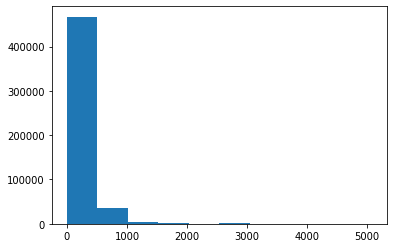

In [6]:
sequence_lengths = np.array([
    len(seq) for seq in sequences
])

max_seq_len = max(sequence_lengths)
word_count = len(word_to_index)

print(f'[+] Max Sequence Length: {max_seq_len}')
print(f'[+] Word Count: {word_count}')

%matplotlib inline
plt.hist(sequence_lengths)

# ToDo: Update the names of these params.
MAX_WORDS = word_count
MAX_SEQ_LEN = 256#max_seq_len

In [7]:
print(f'[+] {len(word_to_index)} words found in {file}')

print('[+] Word Map Subset:\n{')
for acid, index in word_to_index.items():
    print('\t{}: {}'.format(acid, index))
print('}')

[+] 25 words found in /home/das-hund/PycharmProjects/autoencoders/data/pdb_seqres.txt
[+] Word Map Subset:
{
	a: 1
	l: 2
	g: 3
	v: 4
	e: 5
	s: 6
	k: 7
	t: 8
	i: 9
	d: 10
	r: 11
	p: 12
	n: 13
	f: 14
	q: 15
	y: 16
	h: 17
	c: 18
	m: 19
	w: 20
	u: 21
	x: 22
	z: 23
	b: 24
	o: 25
}


#### Data Subset

When training the RNNS, we will need to limit the
length of the data to a multiple of what our batch
size will be. In the future, we will also perform 
the train test split here. But, for now, we just
select a random subset of the data. This will serve
as our development set. 

In [8]:
DATA_LEN = 486400
np.random.shuffle(sequences)
sequences = sequences[:DATA_LEN]

#### Pad Sequences

In [9]:
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQ_LEN)

In [10]:
print(padded_sequences[0:5])
print(padded_sequences.shape)

[[ 2  2  8 ...  3  8  2]
 [ 0  0  0 ... 10  1 14]
 [ 4  4  3 ...  7  5  3]
 [ 4  6 12 ...  1  1  7]
 [ 1  8  2 ...  3 19 19]]
(486400, 256)


In [11]:
#padded_sequences = padded_sequences.reshape((512, 256, 1))

## Model Architecture

Note I'm not using the GLOVE embeddings here.
That would make it difficult to transition this
model to protein sequences. 

In [12]:
from keras.layers.advanced_activations import ELU


def build_encoder(encoder_input, max_seq_len, 
                  latent_dim, intermediate_dim,
                  epsilon_std):
    h = Bidirectional(LSTM(
        intermediate_dim, return_sequences=True, name='lstm_encoding_one'
    ), merge_mode='concat', name='bidirectional_encoding_one')(encoder_input)
    h = Bidirectional(LSTM(
        intermediate_dim // 2, return_sequences=False, name='lstm_encoding_two'
    ), merge_mode='concat', name='bidirectional_encoding_two')(h)

    def sampling(args):
        z_mean_, z_log_var_ = args
        batch_size = K.shape(z_mean_)[0]
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)
        return z_mean_ + K.exp(z_log_var_ / 2) * epsilon
    
    z_mean = Dense(latent_dim, activation='linear', name='z_mean')(h)
    z_log_var = Dense(latent_dim, activation='linear', name='z_log_var')(h)
    
    def vae_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = max_seq_len * objectives.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return xent_loss + kl_loss
    
    latent = Lambda(
        sampling, output_shape=(latent_dim,), name='latent'
    )([z_mean, z_log_var])
    
    return vae_loss, latent


def build_decoder(encoded_input, intermediate_dim,
                  token_count, max_seq_len):
    repeated_context = RepeatVector(
        max_seq_len, name='repeated_context'
    )(encoded_input)
    
    h = LSTM(
        intermediate_dim // 2, return_sequences=True, name='lstm_decoding_one'
    )(repeated_context)
    h = LSTM(
        intermediate_dim, return_sequences=True, name='lstm_decoding_two'
    )(h)
    
    decoded = TimeDistributed(Dense(
        token_count, activation='softmax', name='time_distributed_decoding'
    ), name='decoded_mean')(h)
    
    return decoded
    
    
def build_model(max_seq_len, embedding_dim, token_count,
                batch_size, intermediate_dim, 
                latent_dim, epsilon_std=0.1):
    # ENCODER
    encoder_input = Input(shape=(max_seq_len, 1), name='encoder_input')
    
    vae_loss, encoded = build_encoder(
        encoder_input=encoder_input, max_seq_len=max_seq_len,
        latent_dim=latent_dim, intermediate_dim=intermediate_dim,
        epsilon_std=epsilon_std
    )
    
    encoder = Model(encoder_input, encoded, name='encoder')
    
    # DECODER
    encoded_input = Input(shape=(latent_dim,), name='encoded_input')
    decoded = build_decoder(
        encoded_input=encoded_input, intermediate_dim=intermediate_dim,
        token_count=token_count, max_seq_len=max_seq_len
    )
    
    decoder = Model(encoded_input, decoded, name='decoder')
    
    # VAE
    vae = Model(
        encoder_input, 
        build_decoder(
            encoded_input=encoded, intermediate_dim=intermediate_dim,
            token_count=token_count, max_seq_len=max_seq_len
        ), 
        name='vae')
    vae.compile(
        optimizer='adam',
        loss=vae_loss,
        metrics=['accuracy']
    )
    
    return vae, encoder, decoder


In [13]:
MAX_SEQUENCE_LENGTH = MAX_SEQ_LEN
# EMBID_DIM is an artifact
EMBED_DIM = 4
WORD_COUNT = MAX_WORDS + 1
BATCH_SIZE = 512
STEPS_PER_EPOCH = DATA_LEN // BATCH_SIZE
INTERMEDIATE_DIM = 128
LATENT_DIM = 32
EPOCHS = 10
reload_model = True
        
vae, encoder, decoder = build_model(
    max_seq_len=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    token_count=WORD_COUNT,
    batch_size=BATCH_SIZE,
    intermediate_dim=INTERMEDIATE_DIM,
    latent_dim=LATENT_DIM,
    epsilon_std=0.1
)

if reload_model:
    vae.load_weights('old_bestmodel.weights.hdf5')

Instructions for updating:
Colocations handled automatically by placer.


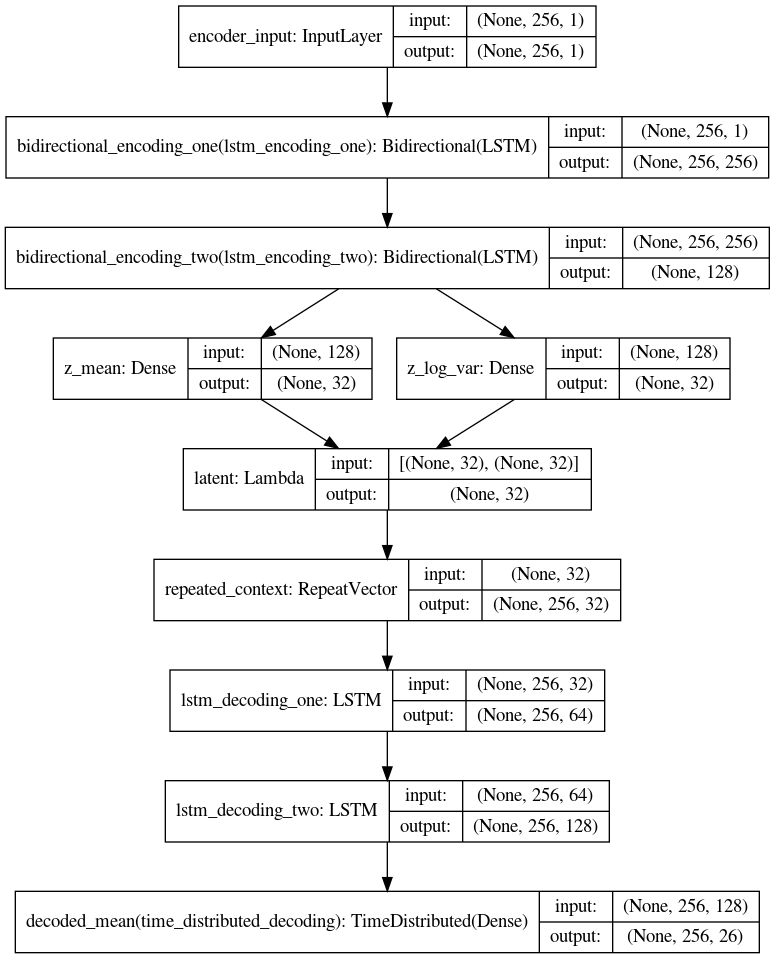

In [14]:
plot_model(vae, show_shapes=True, show_layer_names=True, to_file='vae.png')
Image(retina=True, filename='vae.png')

In [15]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 256, 1)       0                                            
__________________________________________________________________________________________________
bidirectional_encoding_one (Bid (None, 256, 256)     133120      encoder_input[0][0]              
__________________________________________________________________________________________________
bidirectional_encoding_two (Bid (None, 128)          164352      bidirectional_encoding_one[0][0] 
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 32)           4128        bidirectional_encoding_two[0][0] 
__________________________________________________________________________________________________
z_log_var 

In [16]:
def complex_oh_encode(X_train, maxlen, num_words):
    temp = np.zeros((X_train.shape[0], maxlen, num_words))
    temp[
        np.expand_dims(
            np.arange(X_train.shape[0]), axis=0
        ).reshape(
            X_train.shape[0], 1
        ), np.repeat(
            np.array([np.arange(maxlen)]), X_train.shape[0], axis=0
        ), X_train
    ] = 1
    return temp

In [17]:
# Will need this when we get the model working.
def batch_generator(X, batch_size, max_seq_len, num_words):
    indices = np.arange(len(X)) 
    batch=[]
    while True:
        np.random.shuffle(indices) 
        for i in indices:
            batch.append(i)
            if len(batch)==batch_size:
                train = X[batch].reshape((batch_size, max_seq_len, 1))
                yield train, complex_oh_encode(X[batch], maxlen=max_seq_len, num_words=num_words)
                batch=[]

In [18]:
# TODO: Add metrics for KL Div & Expectation
fit_model = True
fit_generator = True

if fit_model:
    checkpoint = ModelCheckpoint(
        'old_bestmodel.weights.hdf5', monitor='loss',
        verbose=1, save_best_only=True, mode='min'
    )
    ## change to monitor loss
    reduce_lr = ReduceLROnPlateau(
        monitor='loss', patience=2, 
        min_lr=0.0001, verbose=1
    )
    callbacks_list = [checkpoint, reduce_lr]
    if fit_generator:
        train_generator = batch_generator(
            X=padded_sequences, 
            batch_size=BATCH_SIZE,
            max_seq_len=MAX_SEQUENCE_LENGTH,
            num_words=WORD_COUNT
        )
        history = vae.fit_generator(
            train_generator, 
            steps_per_epoch=STEPS_PER_EPOCH, 
            epochs=EPOCHS,
            callbacks=callbacks_list
        )
    else:
        trainX = padded_sequences.reshape(
            (DATA_LEN, MAX_SEQ_LEN, 1)
        )
        trainY = complex_oh_encode(
            padded_sequences, 
            maxlen=MAX_SEQ_LEN, 
            num_words=WORD_COUNT
        )
        history = model.fit(
            trainX, trainY,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            callbacks=callbacks_list
        )

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
950/950 [==============================] - 1134s 1s/step - loss: 25.9651 - acc: 0.3833

Epoch 00001: loss improved from inf to 25.96506, saving model to old_bestmodel.weights.hdf5
Epoch 2/10
950/950 [==============================] - 1131s 1s/step - loss: 25.9506 - acc: 0.3836

Epoch 00002: loss improved from 25.96506 to 25.95058, saving model to old_bestmodel.weights.hdf5
Epoch 3/10
950/950 [==============================] - 1131s 1s/step - loss: 25.9694 - acc: 0.3836

Epoch 00003: loss did not improve from 25.95058
Epoch 4/10
950/950 [==============================] - 1131s 1s/step - loss: 25.8839 - acc: 0.3861

Epoch 00004: loss improved from 25.95058 to 25.88393, saving model to old_bestmodel.weights.hdf5
Epoch 5/10
950/950 [==============================] - 1131s 1s/step - loss: 25.9894 - acc: 0.3847

Epoch 00005: loss did not improve from 25.88393
Epoch 6/10
950/950 [==============================] - 1131s 1s/step - loss:

In [19]:
use_saved_model = True
if use_saved_model:
    vae.load_weights('old_bestmodel.weights.hdf5')

In [20]:
predictors = padded_sequences.reshape((DATA_LEN, 256, 1))
preds = vae.predict(predictors[0:10])


In [27]:
for j in range(9):
    print(' '.join([
        index_to_word[i] if i != 0 else ''
        for i in padded_sequences[j]
    ]).strip())
    print()

l l t f t g s g p i g w d m k a r a g k k k v v m e l g g n a p c i v d d y v p d l d y t i q r l i n g g f y q g g q s c i h m q r l y v h e r l y d e v k e g f v a a v k k l k m g n p f e e d t y l g p m i s e s a a k g i e d w v k e a v a k g g k l l t g g n r k g a f i e p t v i e d v p i e a n a r k e e i f g p v v l l y k y s d f k e a v k e c n n t h y g l q s g i f t k d l n k a f y a f e h m e v g g v i l n d s p a l r v d s q p y g g l k d s g i q r e g v k y a m d d m l e t k v l v m r n v g t l

s s h r k r k f s d a f

v v g v l l g s w q k k v l d v s n s f a v p f d e d d k d d s v w f l d h d y l e n m y g m f k k v n a r e r i v g w y h t g p k l h k n d i a i n e l m k r y c p n s v l v i i d v k p k d l g l p t e a y i s v e e v h d d g t p t s k t f e h v t s e i g a e e a e e v g v e h l l r d i k d t t v g t l s q r i t n q v h g l k g l n s k l l d i r s y l e k v a t g k l p i n h q i i y q l q d v f n l l p d v s l q e f v k a f y l k t n d q m v v v y l a s l 

In [24]:
for i in range(9):
    pred_chars = [np.argmax(l) for l in preds[i]]
    print(' '.join([
        index_to_word[i] if i != 0 else '' 
        for i in pred_chars
    ]).strip())
    print()

g l f t s g g g v v e g g g g g v v v v v g g g g g g g l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l

t t t t t t t t t t s s

s v v g l l s l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l 

In [ ]:
#vae.save('vae.h5')
#encoder.save('encoder.h5')
#decoder.save('decoder.h5')

In [ ]:
# Padding
# Attention
# KL Cost Annealing